# Logistic Regression

In [ ]:
import numpy as np

np.random.seed(666)

X_train_fpath = './data/X_train'
Y_train_fpath = './data/Y_train'
X_test_fpath = './data/X_test'
output_fpath = './output_{}.csv'

## 数据预处理 将CSV文件转化为 numpy array

In [ ]:
with open(X_train_fpath) as f:
    # 迭代跳过第一行
    next(f)
    # 读取每一行 第一列是id不取
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

with open(Y_train_fpath) as f:
    next(f)
    # 直接取数据 不取id
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)

with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)


### Normalize

In [ ]:
def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    """
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data
    """
    # 所有列均被归一化
    if specified_column == None:
        # feature 生成随机的np array
        specific_column = np.arange(X.shape[1])
    # 判断是否是训练集
    if train:
        # 对每一列进行计算 进行行压缩
        X_mean = np.mean(X[:, specific_column], 0).reshape(1, -1)
        X_std = np.std(X[:, specific_column], 0).reshape(1, -1)

# 防止分母为0
    X[:, specific_column] = (X[:, specific_column] - X_mean) / (X_std + 1e-8)   
    return X, X_mean, X_std

# 切分训练集和验证集 
def _train_dev_split(X, Y, dev_ratio = 0.25):
    """
    This function spilts data into training set and development set.
    """
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

In [ ]:
# 归一化

X_train, X_mean, X_std = _normalize(X=X_train, train = True)

# 不干涉训练集 做归一化的的mean和std使用训练集的

X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)



# 切分数据集
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio)


### 检查归一化后的数据

In [ ]:
train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

In [ ]:
X_train[:1,:1] # 归一化后所有的值应该是0-1 为什么这个不是呢？？

### some Useful Functions 

In [12]:
# 打乱 但是这函数是干啥的呢。。。下面的步骤没看太懂
def _shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    randomize = np.arange(len(X))
    print(X)
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

# sigmoid func
def _sigmoid(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    # 为了避免overflow 最小值和最大值 为 1e-8和 1 - （1e-8）
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))

# 逻辑回归的函数
def _f(X, w, b):
    # This is the logistic regression function, parameterized by w and b
    #
    # Arguements:
    #     X: input data, shape = [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension, ]
    #     b: bias, scalar
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return _sigmoid(np.matmul(X, w) + b)

# 通过取整返回最后的结果 
def _predict(X, w, b):
    # This function returns a truth value prediction for each row of X 
    # by rounding the result of logistic regression function.
    return np.round(_f(X, w, b)).astype(np.int)

# 正确率 计算函数 
def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

### 梯度以及损失函数计算 

In [13]:
def _cross_entropy_loss(y_pred, Y_label):
    # This function computes the cross entropy.
    #
    # Arguements:
    #     y_pred: probabilistic predictions, float vector
    #     Y_label: ground truth labels, bool vector
    # Output:
    #     cross entropy, scalar
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    # This function computes the gradient of cross entropy loss with respect to weight w and bias b.
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad
    

## Training
使用小批次梯度下降法来训练，训练资料被分为许多小批次，针对一个小批次我们分别计算其梯度以及损失，并根据该批次来更新模型的参数，当跑完一圈，也就是整个训练集的所有批次都被使用过一次后，我们将所有训练资料打撒并且重新分成新的小批次，进行下一圈的计算，直到完成提前设置好的圈数。

In [22]:
# initialization weight and bias
w = np.zeros((data_dim, ))
b = np.zeros((1,))

# some parameters for trining
max_iter = 10
batch_size = 8
learning_rate = 0.2

# keep the loss and accuracy at every iteration for plotting 

train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

step = 1

# 整个跑10轮次
for epoch in range(max_iter):
    # 随机shuffle一下 在背个batch开始前
    X_train, Y_train = _shuffle(X_train, Y_train)

    # batch training 
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx * batch_size : (idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]

        w_grad, b_grad = _gradient(X, Y, w, b)

        ## 学习率随着时间衰减 梯度更新 
        w = w - learning_rate / np.sqrt(step) * w_grad

        step += 1
    
    # 计算loss 和 accuracy
    y_train_pred = _f(X_train, w, b)
    Y_train_perd = np.round(y_train_pred)
    train_acc.append(_accuracy(Y_train_perd,Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)

    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)  


print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))




Training loss: 0.4264275783369703
Development loss: 0.4355766604976902
Training accuracy: 0.8553962727831251
Development accuracy: 0.8427939550313306


## 画图


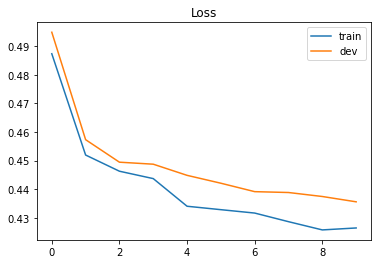

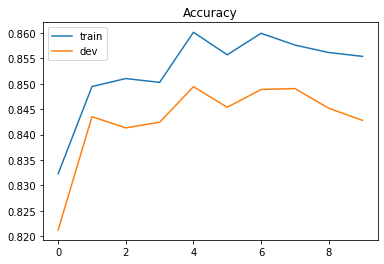

In [23]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.show()

# Accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.show()

In [24]:
## Predicting testing labels
# 保存预测的情况

predictions = _predict(X_test, w, b)
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
#  权重排序 
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Unemployed full-time 6.0978811933529125
 Other Rel <18 never marr not in subfamily -3.098969760728158
 Other Rel <18 never marr child of subfamily RP -1.5111004422178738
 6 1.292056081809513
capital losses 1.13006929735138
 Local government -0.6401859165434327
 10 0.5626961386128767
 Other Rel <18 ever marr RP of subfamily -0.5215185701132088
 Child 18+ never marr RP of subfamily -0.48899699749165454
 Grandchild <18 never marr not in subfamily -0.48165132058428334


# Probalistic generative Model
传统的方法 这里就不再去重复了